# Co-Culture Simulation 

In [ ]:
import os
os.environ['GUROBI_COMETS_HOME'] = '/Library/gurobi1003/macos_universal2'
os.environ['COMETS_HOME'] = '/Users/fredericksenya/Documents/MATLAB/comets_macos/comets_2.12.3'
os.environ['CLASSPATH'] = f"{os.environ['COMETS_HOME']}/comets.jar:{os.environ['GUROBI_COMETS_HOME']}/lib/gurobi.jar"
os.environ['DYLD_LIBRARY_PATH'] = f"{os.environ['GUROBI_COMETS_HOME']}/lib"
os.environ['GRB_LICENSE_FILE'] = '/Library/gurobi1003/macos_universal2/gurobi.lic'

import cobra as cb
import cometspy as c
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [5]:
VOL = 1e-3                        # cm³  
SPACE_WIDTH = VOL ** (1/3)         # 0.1 cm = 1 mm
BOX_VOL_CM3 = SPACE_WIDTH ** 3     # VOL
BOX_VOL_L  = BOX_VOL_CM3 * 1e-3   # 1e-6 L

def mM_to_mmol(conc_mM):
    'concentration to mmol'
    return conc_mM * BOX_VOL_L

def mmol_to_mM(amount_mmol):
    'mmol to concentration'
    return amount_mmol / BOX_VOL_L

# parameters
DEFAULT_VMAX = 20.0       # mmol/gDW/h
DEFAULT_KM   = 5e-4       # mmol/cm³  (= 0.5 mM)
DEFAULT_HILL  = 1

TIME_STEP  = 0.01         
MAX_CYCLES = 150           
LOG_RATE   = 1           

t_step = TIME_STEP        
t_total = MAX_CYCLES

INIT_BIOMASS = 5e-7       # g  
MAX_SPACE_BIOMASS = 1e-2  # g
MIN_SPACE_BIOMASS = 1e-14 # g

# concentrations 
GLC_CONC_mM  = 10.0      # glucose
NH4_CONC_mM  = 5.0       # ammonium
ION_CONC_mM  = 5.0       # major ions
AA_CONC_mM   = 2.0       # amino acids
TRACE_CONC_mM = 0.1      # trace metals & vitamins
WATER_AMOUNT  = 1e-4     # mmol 

# media
water_proton_ids = {'h2o[e]'}
major_ion_ids    = {'pi[e]', 'so4[e]', 'k[e]', 'cl[e]', 'mg2[e]', 'ca2[e]'}
trace_metal_ids  = {'fe2[e]', 'fe3[e]', 'zn2[e]', 'cu2[e]', 'mn2[e]', 'cobalt2[e]', 'cd2[e]'}
vitamin_ids      = {'ribflv[e]', 'pnto_R[e]', 'nac[e]', 'hxan[e]'}
aa_ids           = {'ala_L[e]', 'asn_L[e]', 'his_L[e]', 'leu_L[e]', 'lys_L[e]',
                    'met_L[e]', 'glycys[e]', 'glyglu[e]'}

# Combined set 
background_met_ids = water_proton_ids | major_ion_ids | trace_metal_ids | vitamin_ids | aa_ids | {'nh4[e]'}


def classify_and_set_media(layout, all_ex_mets):

    for met in all_ex_mets:
        layout.set_specific_metabolite(met, 0.0)
        layout.set_specific_refresh(met, 0.0)

    for met in all_ex_mets:
        if met in water_proton_ids:
            layout.set_specific_metabolite(met, WATER_AMOUNT)
            layout.set_specific_static(met, WATER_AMOUNT)
        elif met in major_ion_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(ION_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(ION_CONC_mM))
        elif met in trace_metal_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in vitamin_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(TRACE_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(TRACE_CONC_mM))
        elif met in aa_ids:
            layout.set_specific_metabolite(met, mM_to_mmol(AA_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(AA_CONC_mM))
        elif met == 'nh4[e]':
            layout.set_specific_metabolite(met, mM_to_mmol(NH4_CONC_mM))
            layout.set_specific_static(met, mM_to_mmol(NH4_CONC_mM))


def make_params():
   
    params = c.params()
    params.set_param('spaceWidth',       SPACE_WIDTH)
    params.set_param('defaultVmax',      DEFAULT_VMAX)
    params.set_param('defaultKm',        DEFAULT_KM)
    params.set_param('defaultHill',      DEFAULT_HILL)
    params.set_param('exchangestyle',    'Monod Style')
    params.set_param('timeStep',         TIME_STEP)
    params.set_param('maxCycles',        MAX_CYCLES)
    params.set_param('maxSpaceBiomass',  MAX_SPACE_BIOMASS)
    params.set_param('minSpaceBiomass',  MIN_SPACE_BIOMASS)
    params.set_param('writeMediaLog',    True)
    params.set_param('MediaLogRate',     LOG_RATE)
    params.set_param('writeFluxLog',     True)
    params.set_param('FluxLogRate',      LOG_RATE)
    params.set_param('writeBiomassLog',  True)
    params.set_param('BiomassLogRate',   LOG_RATE)
    return params


def clean_non_ex(comets_model):
    'COMETS bug fix'
    ex_mask = comets_model.reactions['EXCH'].isin([True, 'True'])
    for name in comets_model.reactions.loc[ex_mask, 'REACTION_NAMES']:
        name = str(name)
        if not name.startswith('EX_'):
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH'] = False
            comets_model.reactions.loc[
                comets_model.reactions['REACTION_NAMES'] == name, 'EXCH_IND'] = 0

print(f'Glucose: {GLC_CONC_mM} mM  → {mM_to_mmol(GLC_CONC_mM):.2e} mmol/box')

Glucose: 10.0 mM  → 1.00e-05 mmol/box


In [8]:
#Load COBRA models
base1 = cb.io.load_matlab_model('Bifidobacterium_longum_infantis_ATCC_15697.mat')
base1.id = 'Bifido'
base2 = cb.io.load_matlab_model('Eubacterium_hallii_DSM_3353.mat')
base2.id = 'Eubacterium'

#default bounds for all exchanges
for m in [base1, base2]:
    for rxn in m.exchanges:
        rxn.lower_bound = 0.0
        rxn.upper_bound = 1000.0

#metabolite to exchange reaction mappings
met_to_ex1 = {}
for rxn in base1.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex1[met.id] = rxn.id

met_to_ex2 = {}
for rxn in base2.exchanges:
    if rxn.metabolites:
        met = list(rxn.metabolites.keys())[0]
        met_to_ex2[met.id] = rxn.id

# Union of all external metabolites
all_ext_mets = set(met_to_ex1.keys()) | set(met_to_ex2.keys())

def add_missing_closed_exchanges(model, met_to_ex_self_real, all_ext_mets, label):
    'Comets bug fix'
    met_ids = {m.id for m in model.metabolites}
    rxn_ids = {r.id for r in model.reactions}

    for met_id in all_ext_mets:
        if met_id in met_to_ex_self_real:
            continue

        if met_id in met_ids:
            met = model.metabolites.get_by_id(met_id)
        else:
            met = cb.Metabolite(met_id, compartment='e')
            model.add_metabolites([met])
            met_ids.add(met_id)
            #print(f"[{label}] Added external metabolite {met_id}")

        rxn_id = f"EX_added_{met_id}"
        if rxn_id in rxn_ids:
            continue

        rxn = cb.Reaction(rxn_id)
        rxn.name = f"Dummy exchange for {met_id} (closed)"
        rxn.lower_bound = 0.0
        rxn.upper_bound = 0.0
        rxn.add_metabolites({met: -1.0})
        model.add_reactions([rxn])
        rxn_ids.add(rxn_id)
        #print(f"[{label}] Added CLOSED dummy exchange {rxn_id} for {met_id}")

add_missing_closed_exchanges(base1, met_to_ex1, all_ext_mets, "Bifido")
add_missing_closed_exchanges(base2, met_to_ex2, all_ext_mets, "Eubacterium")

No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e
No defined compartments in model model. Compartments will be deduced heuristically using regular expressions.
Using regular expression found the following compartments:c, e


In [13]:
# COMETS models 
Comets_Bifido = c.model(base1)
Comets_Eubacterium = c.model(base2)

Comets_Bifido.open_exchanges()
Comets_Eubacterium.open_exchanges()

# Clean non-EX exchanges
for m in [Comets_Bifido, Comets_Eubacterium]:
    clean_non_ex(m)


Comets_Bifido.initial_pop = [0, 0, INIT_BIOMASS]
Comets_Eubacterium.initial_pop = [0, 0, INIT_BIOMASS]

# Layout
def create_layout(models):
    if not isinstance(models, list):
        models = [models]

    layout = c.layout()
    for model in models:
        layout.add_model(model)

    # Set media
    classify_and_set_media(layout, all_ext_mets)

    # Set glucose
    layout.set_specific_metabolite('glc_D[e]', mM_to_mmol(GLC_CONC_mM))
    layout.set_specific_refresh('glc_D[e]', 0.0)

    # track secreted metabolites
    for met in all_ext_mets:
        if met not in background_met_ids and met != 'glc_D[e]':
            layout.set_specific_metabolite(met, 0.0)

    return layout

In [ ]:
# simulation

# Monoculture Bifido
print("Running Bifido monoculture...")
layout_mono_Bifido = create_layout(Comets_Bifido)
params_mono_b = make_params()
sim_mono_Bifido = c.comets(layout_mono_Bifido, params_mono_b)
sim_mono_Bifido.run()

# Monoculture Eubacterium
print("\nRunning Eubacterium monoculture...")
layout_mono_Eubacterium = create_layout(Comets_Eubacterium)
params_mono_e = make_params()
sim_mono_Eubacterium = c.comets(layout_mono_Eubacterium, params_mono_e)
sim_mono_Eubacterium.run()

# Co-culture
print("\nRunning co-culture...")
layout_co = create_layout([Comets_Bifido, Comets_Eubacterium])
params_co = make_params()
sim_co = c.comets(layout_co, params_co)
sim_co.run()


Running Bifido monoculture...
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!

Running Eubacterium monoculture...
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!

Running co-culture...
building empty layout model
models will need to be added with layout.add_model()

Running COMETS simulation ...

Debug Here ...
Done!

All simulations complete.


In [16]:
# data
time_co = np.arange(len(sim_co.total_biomass)) * t_step
time_mono_bifido = np.arange(len(sim_mono_Bifido.total_biomass)) * t_step
time_mono_eubact = np.arange(len(sim_mono_Eubacterium.total_biomass)) * t_step

# Co-culture biomass
biomass_co_bifido = sim_co.total_biomass['Bifido'].values
biomass_co_eubact = sim_co.total_biomass['Eubacterium'].values

# Monoculture biomass
biomass_mono_bifido = sim_mono_Bifido.total_biomass['Bifido'].values
biomass_mono_eubact = sim_mono_Eubacterium.total_biomass['Eubacterium'].values

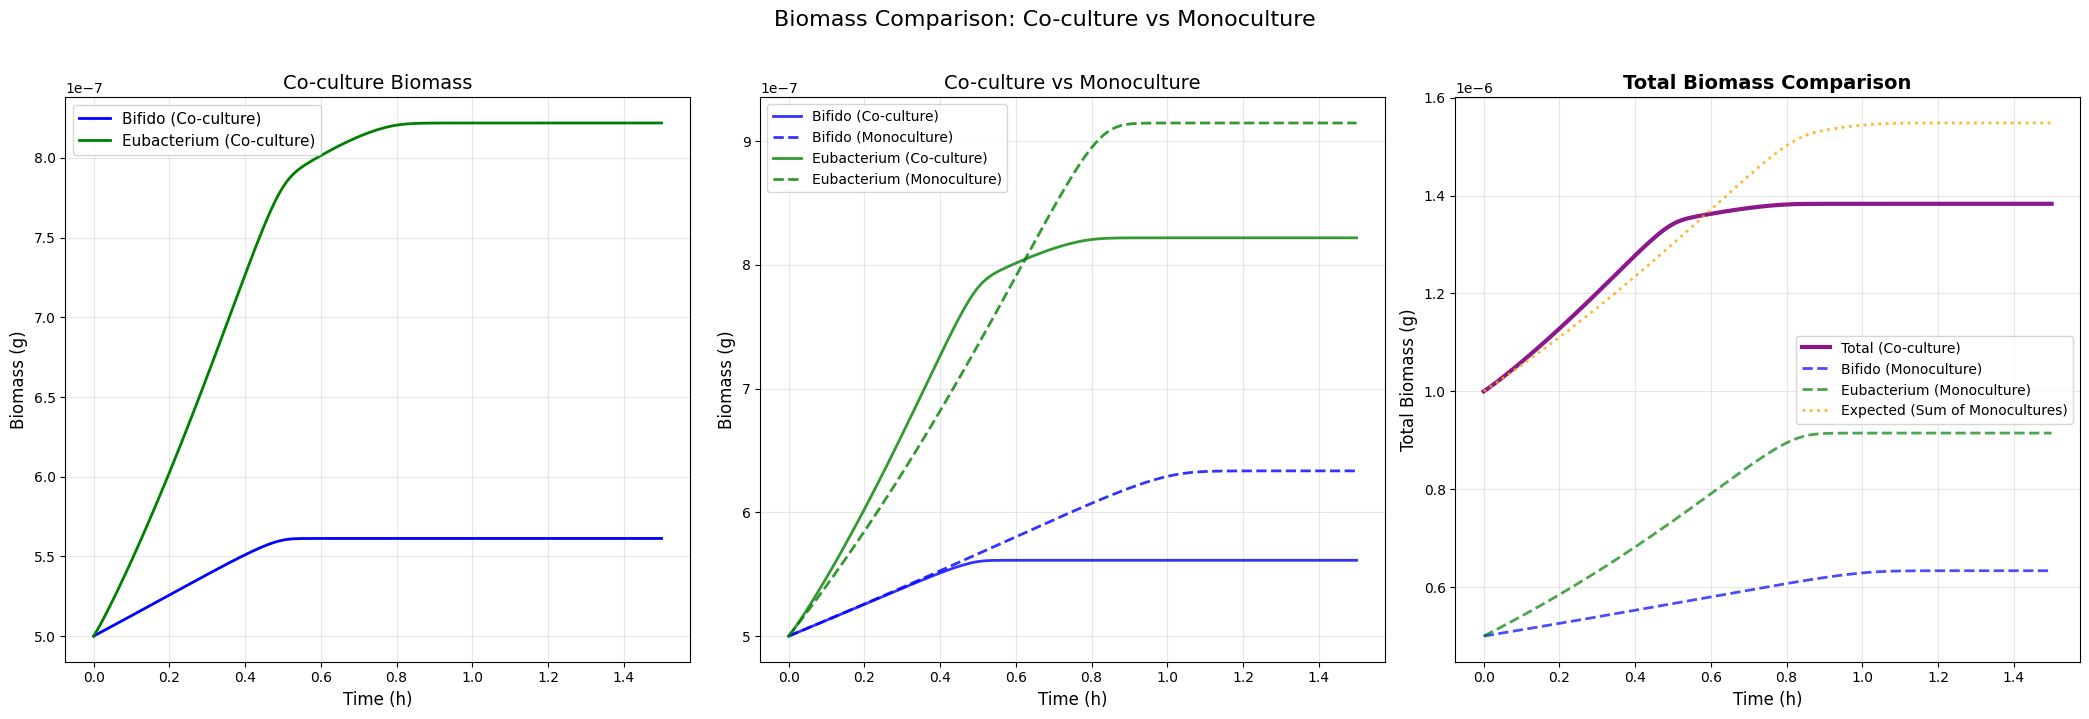

In [21]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7))
fig.suptitle('Biomass Comparison: Co-culture vs Monoculture',
                 fontsize=16, y=1.02)

# Subplot 1: Co-culture biomass 
ax = axes[0]
ax.plot(time_co, biomass_co_bifido, 'b-', linewidth=2, label='Bifido (Co-culture)')
ax.plot(time_co, biomass_co_eubact, 'g-', linewidth=2, label='Eubacterium (Co-culture)')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Biomass (g)', fontsize=12)
ax.set_title('Co-culture Biomass', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)


# Subplot 2: Co-culture vs Monoculture
ax = axes[1]
ax.plot(time_co, biomass_co_bifido, 'b-', linewidth=2, label='Bifido (Co-culture)', alpha=0.8)
ax.plot(time_mono_bifido, biomass_mono_bifido, 'b--', linewidth=2, label='Bifido (Monoculture)', alpha=0.8)
ax.plot(time_co, biomass_co_eubact, 'g-', linewidth=2, label='Eubacterium (Co-culture)', alpha=0.8)
ax.plot(time_mono_eubact, biomass_mono_eubact, 'g--', linewidth=2, label='Eubacterium (Monoculture)', alpha=0.8)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Biomass (g)', fontsize=12)
ax.set_title('Co-culture vs Monoculture', fontsize=14)
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)


# Subplot 3: Total biomass comparison
total_biomass_co = biomass_co_bifido + biomass_co_eubact

ax = axes[2]
ax.plot(time_co, total_biomass_co, 'purple', linewidth=3, label='Total (Co-culture)', alpha=0.9)
ax.plot(time_mono_bifido, biomass_mono_bifido, 'b--', linewidth=2, label='Bifido (Monoculture)', alpha=0.7)
ax.plot(time_mono_eubact, biomass_mono_eubact, 'g--', linewidth=2, label='Eubacterium (Monoculture)', alpha=0.7)

min_len = min(len(time_co), len(time_mono_bifido), len(time_mono_eubact))
expected_total = biomass_mono_bifido[:min_len] + biomass_mono_eubact[:min_len]
ax.plot(time_co[:min_len], expected_total, 'orange', linewidth=2, linestyle=':',
        label='Expected (Sum of Monocultures)', alpha=0.8)

ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Total Biomass (g)', fontsize=12)
ax.set_title('Total Biomass Comparison', fontsize=14, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(alpha=0.3)


plt.tight_layout()
plt.show()

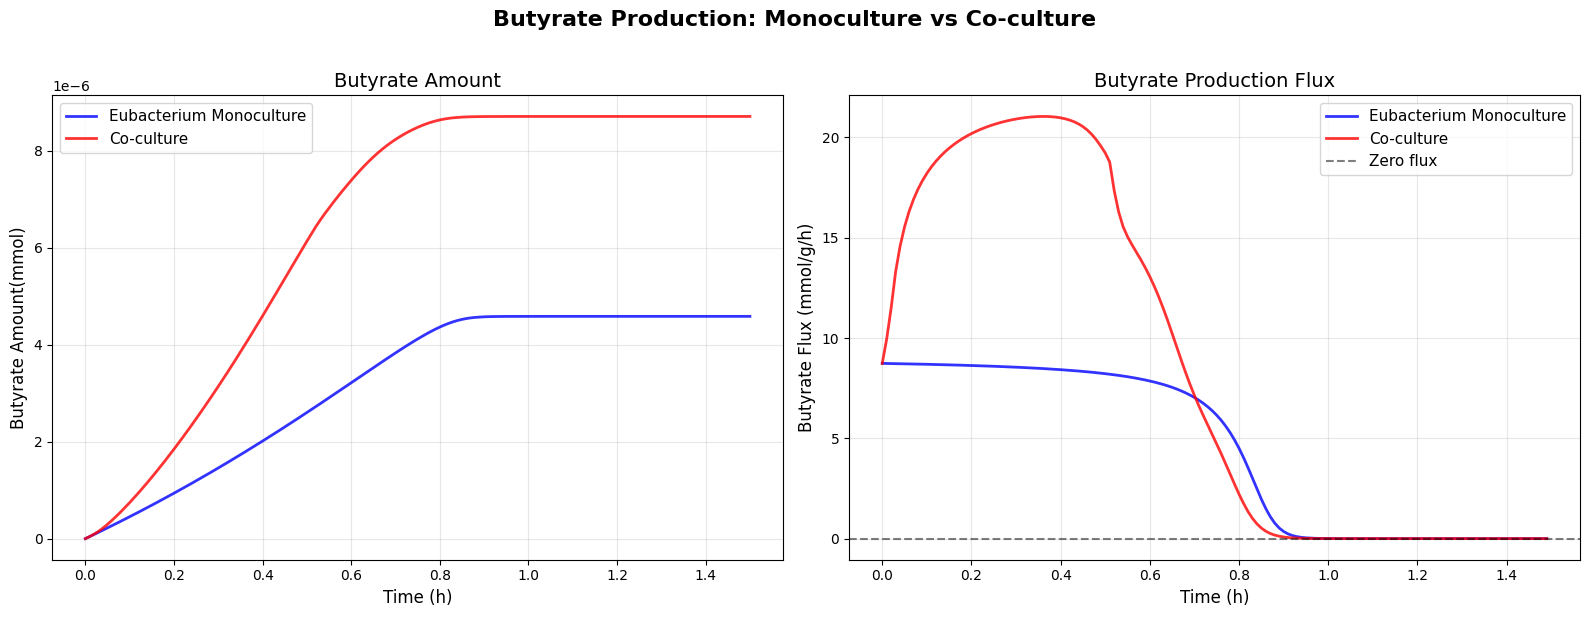

In [65]:
# Butyrate Production
def get_met_data(sim, metabolite):
    media = sim.get_metabolite_time_series()
    if metabolite in media.columns:
        return media[metabolite].values
    else:
        return np.zeros(len(media))

# time
time_mono_eubact = np.arange(len(sim_mono_Eubacterium.total_biomass)) * t_step
time_co = np.arange(len(sim_co.total_biomass)) * t_step

# butyrate amount
but_mono_eubact = get_met_data(sim_mono_Eubacterium, 'but[e]')    #/ BOX_VOL_L
but_co = get_met_data(sim_co, 'but[e]') 

# butyrate fluxes
flux_mono_eubact = sim_mono_Eubacterium.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)
flux_eubact_co = sim_co.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)

time_flux_mono_eubact = np.arange(len(flux_mono_eubact)) * t_step
time_flux_eubact_co = np.arange(len(flux_eubact_co)) * t_step

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Butyrate Production: Monoculture vs Co-culture',
             fontsize=16, fontweight='bold', y=1.02)

# Subplot 1: Butyrate concentration
ax = axes[0]
ax.plot(time_mono_eubact, but_mono_eubact, 'b-', linewidth=2, label='Eubacterium Monoculture', alpha=0.8)
ax.plot(time_co, but_co, 'r-', linewidth=2, label='Co-culture', alpha=0.8)
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate Amount(mmol)', fontsize=12)
ax.set_title('Butyrate Amount', fontsize=14)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)


# Subplot 2: Butyrate flux
ax = axes[1]

but_flux_mono_eubact = flux_mono_eubact['EX_but(e)'].values
but_flux_eubact_co = flux_eubact_co['EX_but(e)'].values
time_mono_flux = time_flux_mono_eubact[:len(but_flux_mono_eubact)]
time_co_flux = time_flux_eubact_co[:len(but_flux_eubact_co)]

ax.plot(time_mono_flux, but_flux_mono_eubact, 'b-', linewidth=2,
            label='Eubacterium Monoculture', alpha=0.8)

ax.plot(time_co_flux, but_flux_eubact_co, 'r-', linewidth=2,
            label='Co-culture', alpha=0.8)

ax.axhline(y=0, color='k', linestyle='--', linewidth=1.5, alpha=0.5, label='Zero flux')
ax.set_xlabel('Time (h)', fontsize=12)
ax.set_ylabel('Butyrate Flux (mmol/g/h)', fontsize=12)
ax.set_title('Butyrate Production Flux', fontsize=14)
ax.legend(fontsize=11, loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


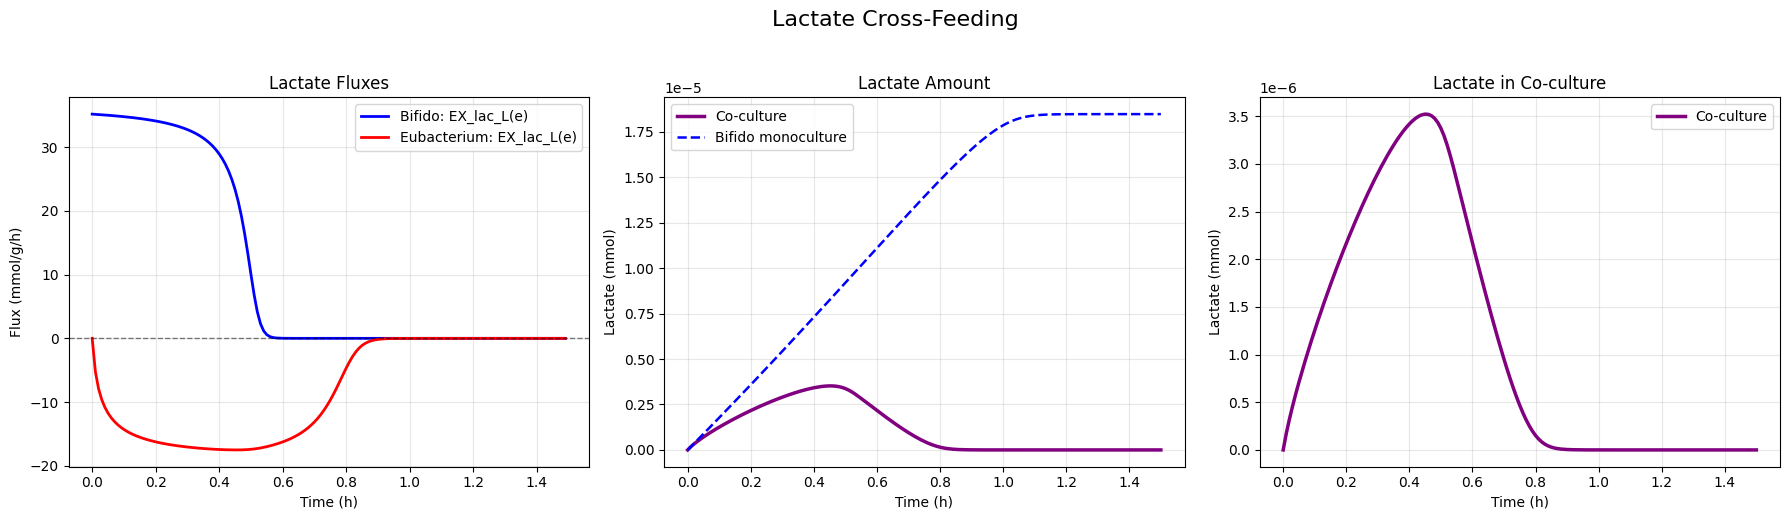

In [53]:
#Lactate 

flux_bifido_co = sim_co.get_species_exchange_fluxes('Bifido',      threshold=1e-8)
flux_eubact_co = sim_co.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)

bifido_lac_flux = flux_bifido_co['EX_lac_L(e)'].values 
eubact_lac_flux = flux_eubact_co['EX_lac_L(e)'].values 

# Metabolite amount
media_co            = sim_co.get_metabolite_time_series()
media_mono_bifido   = sim_mono_Bifido.get_metabolite_time_series()
#media_mono_eubact   = sim_mono_Eubacterium.get_metabolite_time_series()
lac_co          = media_co['lac_L[e]'].values         
lac_mono_bifido = media_mono_bifido['lac_L[e]'].values 


fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Lactate Cross-Feeding', fontsize=16, y=1.03)

# Subplot 1: Lactate fluxes 
ax = axes[0]
t = np.arange(len(bifido_lac_flux)) * t_step
ax.plot(t, bifido_lac_flux, 'b-', lw=2, label='Bifido: EX_lac_L(e)')

t = np.arange(len(eubact_lac_flux)) * t_step
ax.plot(t, eubact_lac_flux, 'r-', lw=2, label='Eubacterium: EX_lac_L(e)')

ax.axhline(0, color='k', ls='--', lw=1, alpha=0.5)
ax.set_xlabel('Time (h)')
ax.set_ylabel('Flux (mmol/g/h)')
ax.set_title('Lactate Fluxes')
ax.legend()
ax.grid(alpha=0.3)

# Subplot 2: Lactate amount
ax = axes[1]
t = np.arange(len(lac_co)) * t_step
ax.plot(t, lac_co, 'purple', lw=2.5, label='Co-culture')

t = np.arange(len(lac_mono_bifido)) * t_step
ax.plot(t, lac_mono_bifido, 'b--', lw=1.8, label='Bifido monoculture')

ax.set_xlabel('Time (h)')
ax.set_ylabel('Lactate (mmol)')
ax.set_title('Lactate Amount')
ax.legend()
ax.grid(alpha=0.3)

#Subplot 3: Co-culture lactate
ax = axes[2]
t = np.arange(len(lac_co)) * t_step
ax.plot(t, lac_co, 'purple', lw=2.5, label='Co-culture')

ax.set_xlabel('Time (h)')
ax.set_ylabel('Lactate (mmol)')
ax.set_title('Lactate in Co-culture')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

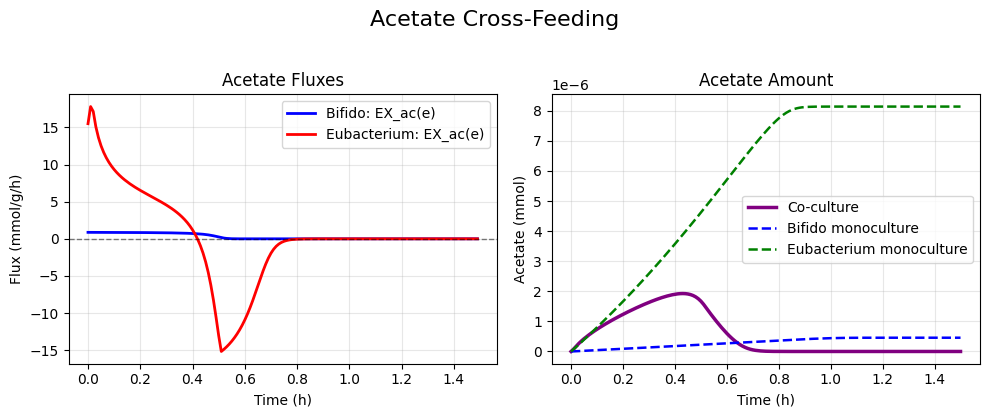

In [ ]:
#Lactate 

flux_bifido_co = sim_co.get_species_exchange_fluxes('Bifido',      threshold=1e-8)
flux_eubact_co = sim_co.get_species_exchange_fluxes('Eubacterium', threshold=1e-8)

bifido_lac_flux = flux_bifido_co['EX_ac(e)'].values 
eubact_lac_flux = flux_eubact_co['EX_ac(e)'].values 

# Metabolite amount
media_co            = sim_co.get_metabolite_time_series()
media_mono_bifido   = sim_mono_Bifido.get_metabolite_time_series()
media_mono_eubact   = sim_mono_Eubacterium.get_metabolite_time_series()
lac_co          = media_co['ac[e]'].values         
lac_mono_bifido = media_mono_bifido['ac[e]'].values 
lac_mono_eubact = media_mono_eubact['ac[e]'].values

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
fig.suptitle('Acetate Cross-Feeding', fontsize=16, y=1.03)

# Subplot 1: Lactate fluxes 
ax = axes[0]
t = np.arange(len(bifido_lac_flux)) * t_step
ax.plot(t, bifido_lac_flux, 'b-', lw=2, label='Bifido: EX_ac(e)')

t = np.arange(len(eubact_lac_flux)) * t_step
ax.plot(t, eubact_lac_flux, 'r-', lw=2, label='Eubacterium: EX_ac(e)')

ax.axhline(0, color='k', ls='--', lw=1, alpha=0.5)
ax.set_xlabel('Time (h)')
ax.set_ylabel('Flux (mmol/g/h)')
ax.set_title('Acetate Fluxes')
ax.legend()
ax.grid(alpha=0.3)

# Subplot 2: Lactate amount
ax = axes[1]
t = np.arange(len(lac_co)) * t_step
ax.plot(t, lac_co, 'purple', lw=2.5, label='Co-culture')

t = np.arange(len(lac_mono_bifido)) * t_step
ax.plot(t, lac_mono_bifido, 'b--', lw=1.8, label='Bifido monoculture')

t = np.arange(len(lac_mono_eubact)) * t_step
ax.plot(t, lac_mono_eubact, 'g--', lw=1.8, label='Eubacterium monoculture')

ax.set_xlabel('Time (h)')
ax.set_ylabel('Acetate (mmol)')
ax.set_title('Acetate Amount')
ax.legend()
ax.grid(alpha=0.3)


plt.tight_layout()
plt.show()

Found 35 metabolites with significant changes
Metabolites: ['4abut[e]', 'ac[e]', 'ala_L[e]', 'asn_L[e]', 'but[e]', 'ca2[e]', 'cd2[e]', 'cl[e]', 'co2[e]', 'cobalt2[e]', 'cu2[e]', 'fe2[e]', 'fe3[e]', 'glc_D[e]', 'glycys[e]', 'glyglu[e]', 'h2[e]', 'h2o[e]', 'h[e]', 'his_L[e]']...


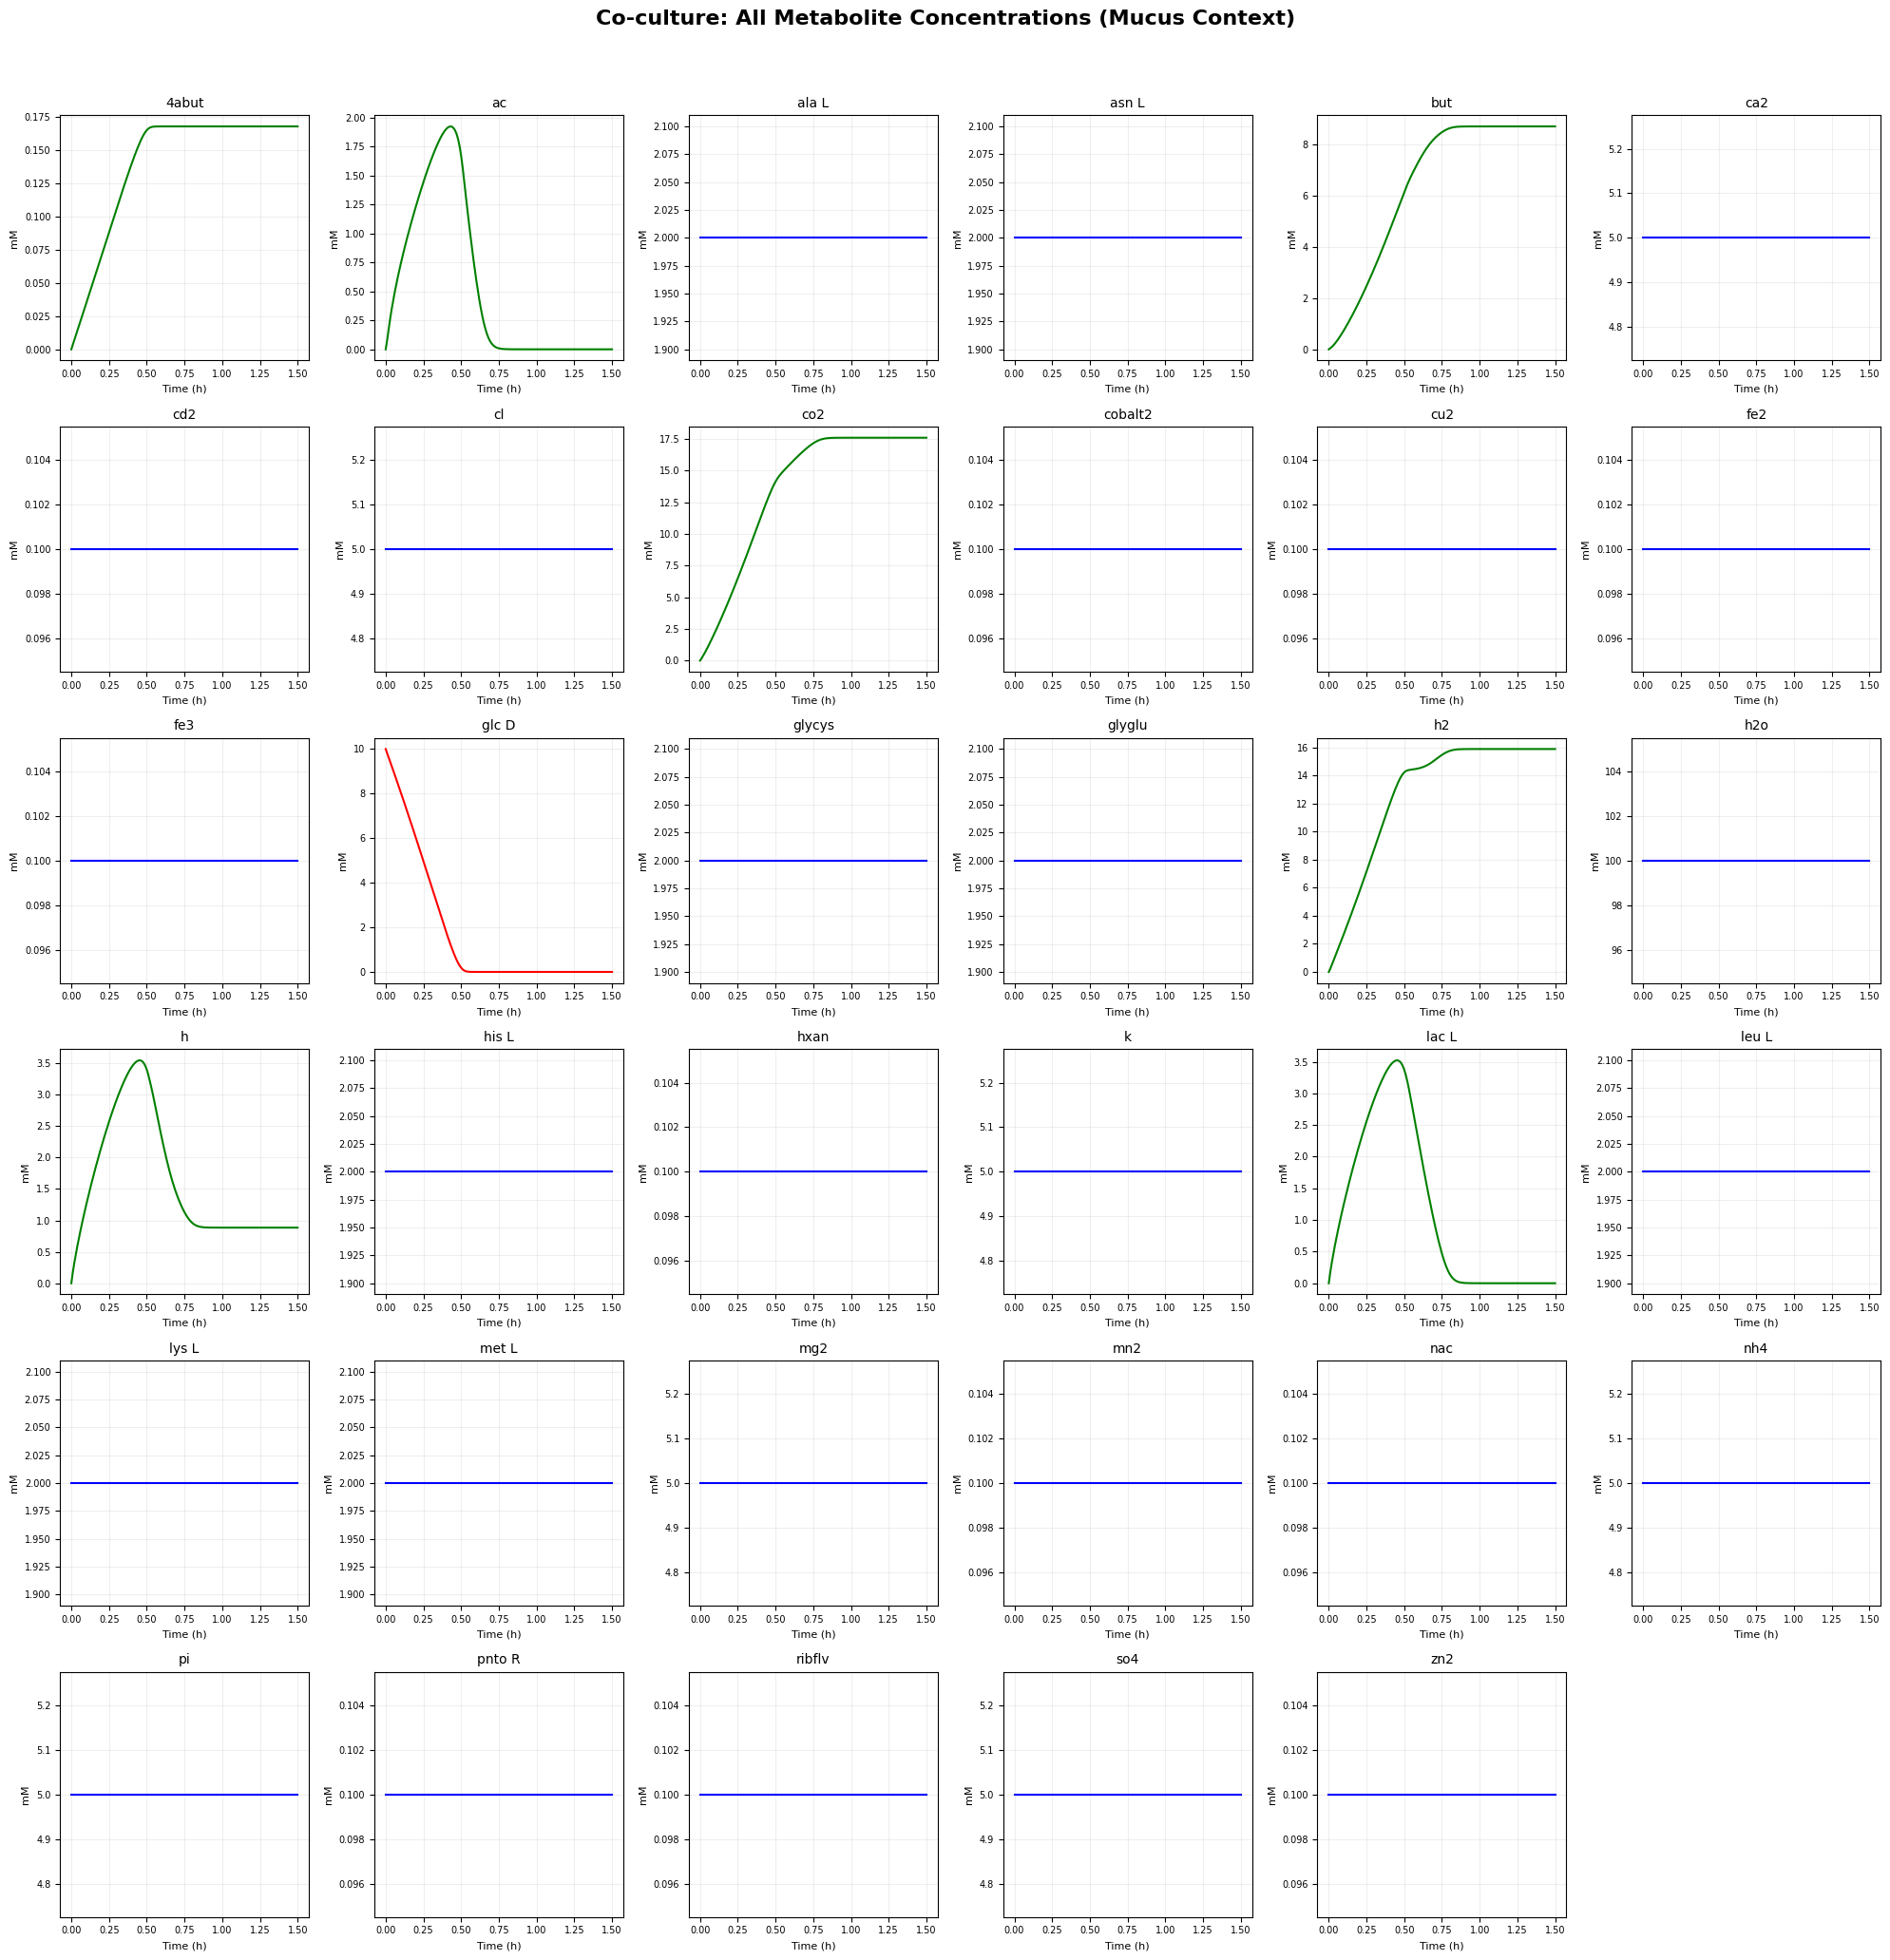

In [72]:
# all metaboi
media_co = sim_co.get_metabolite_time_series()
time_co = np.arange(len(media_co)) * t_step

all_metabolites = sorted([col for col in media_co.columns
                          if col != 'cycle' and 'biomass' not in col.lower()])

# Filter to metabolites with significant changes
significant_mets = []
for met in all_metabolites:
    conc = media_co[met].values / BOX_VOL_L  # convert to mM
    if len(conc) > 0:
        if conc.max() - conc.min() > 0.01 or conc[0] > 0.01 or conc[-1] > 0.01:
            significant_mets.append(met)

print(f"Found {len(significant_mets)} metabolites with significant changes")
print(f"Metabolites: {significant_mets[:20]}...")

num_mets = len(significant_mets)
cols = 6
rows = math.ceil(num_mets / cols)

fig, axes = plt.subplots(rows, cols, figsize=(20, 3.5 * rows))
fig.suptitle('Co-culture: All Metabolite Concentrations (Mucus Context)',
             fontsize=16, fontweight='bold', y=0.98)

if rows == 1:
    axes = axes.reshape(1, -1)
elif cols == 1:
    axes = axes.reshape(-1, 1)

for i, met in enumerate(significant_mets):
    row = i // cols
    col = i % cols

    if row < axes.shape[0] and col < axes.shape[1]:
        ax = axes[row, col]
        conc = media_co[met].values / BOX_VOL_L  # convert to mM

        if len(conc) > 0:
            if conc[0] > 0.01 and conc[-1] < 0.01:
                line_color = 'red'
            elif conc[0] < 0.01 and conc.max() > 0.01:
                line_color = 'green'
            else:
                line_color = 'blue'
        else:
            line_color = 'blue'

        ax.plot(time_co, conc, color=line_color, linewidth=1.5)
        ax.set_xlabel('Time (h)', fontsize=8)
        ax.set_ylabel('mM', fontsize=8)
        met_name = met.replace('[e]', '').replace('_', ' ')
        ax.set_title(met_name, fontsize=10)
        ax.grid(alpha=0.2)
        ax.tick_params(axis='both', which='major', labelsize=7)

# Remove empty subplots
for i in range(len(significant_mets), rows * cols):
    row = i // cols
    col = i % cols
    if row < axes.shape[0] and col < axes.shape[1]:
        fig.delaxes(axes[row, col])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


Bifido: 29 significant exchange fluxes


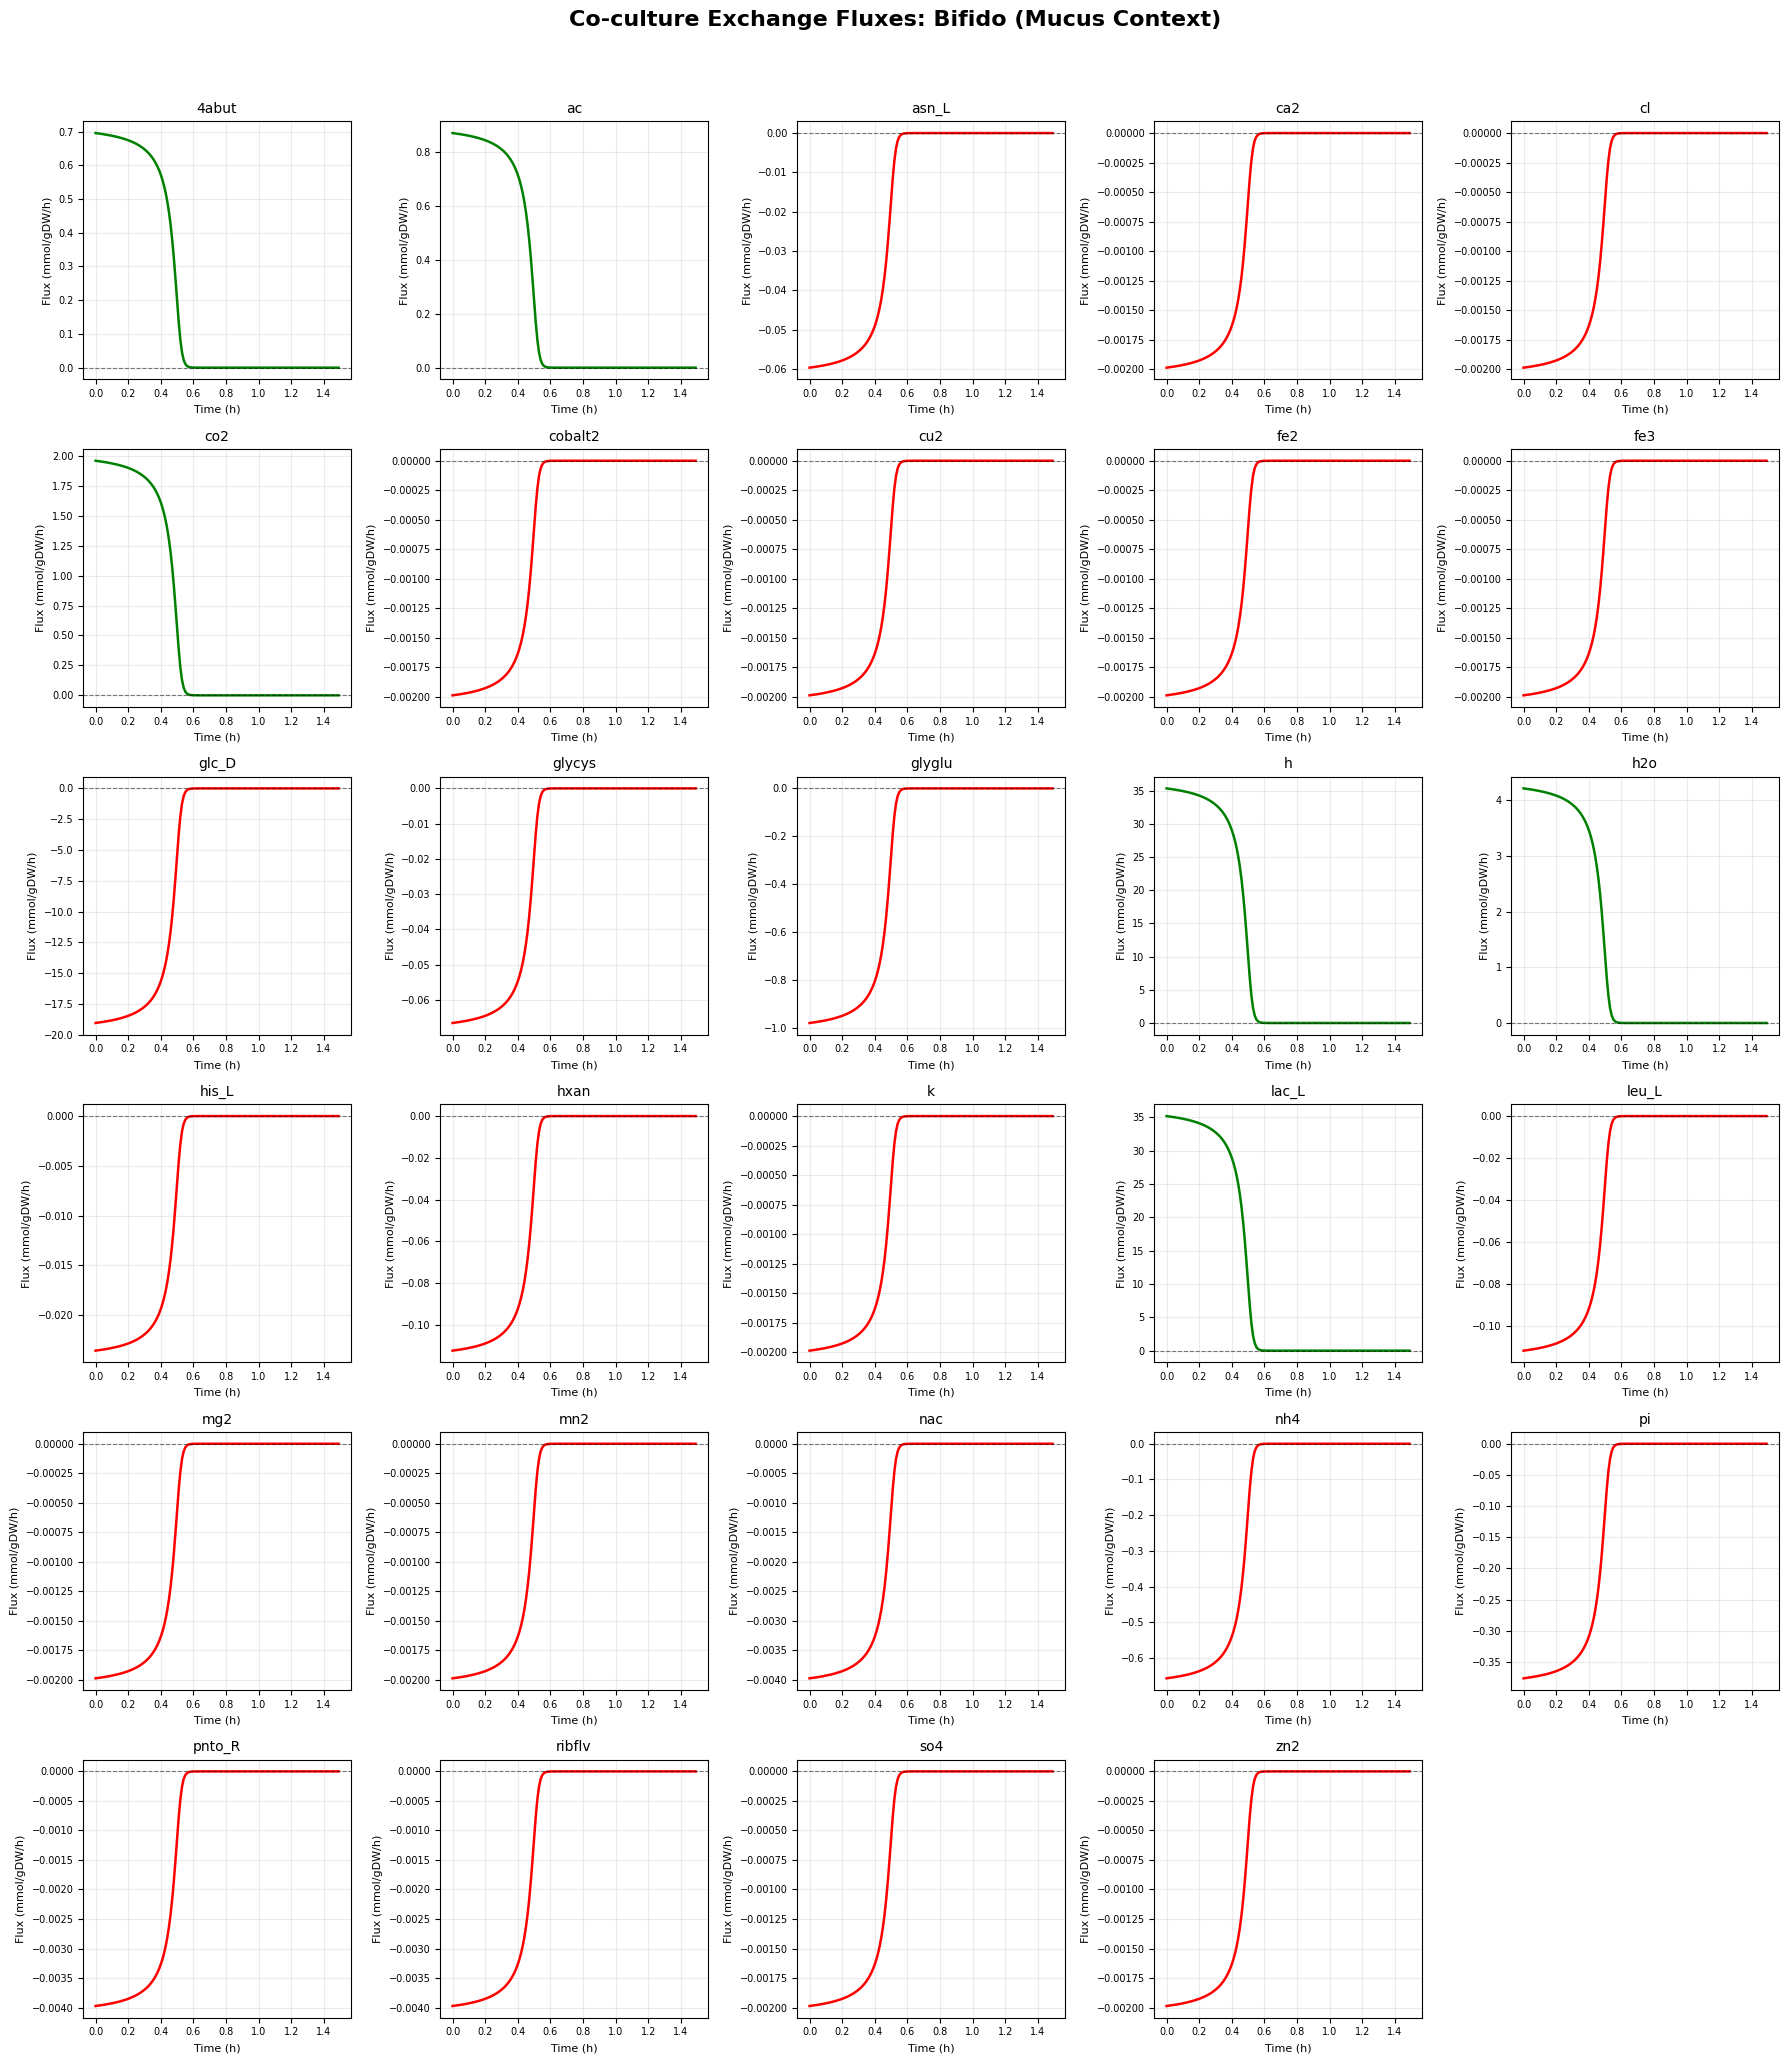

Eubacterium: 32 significant exchange fluxes


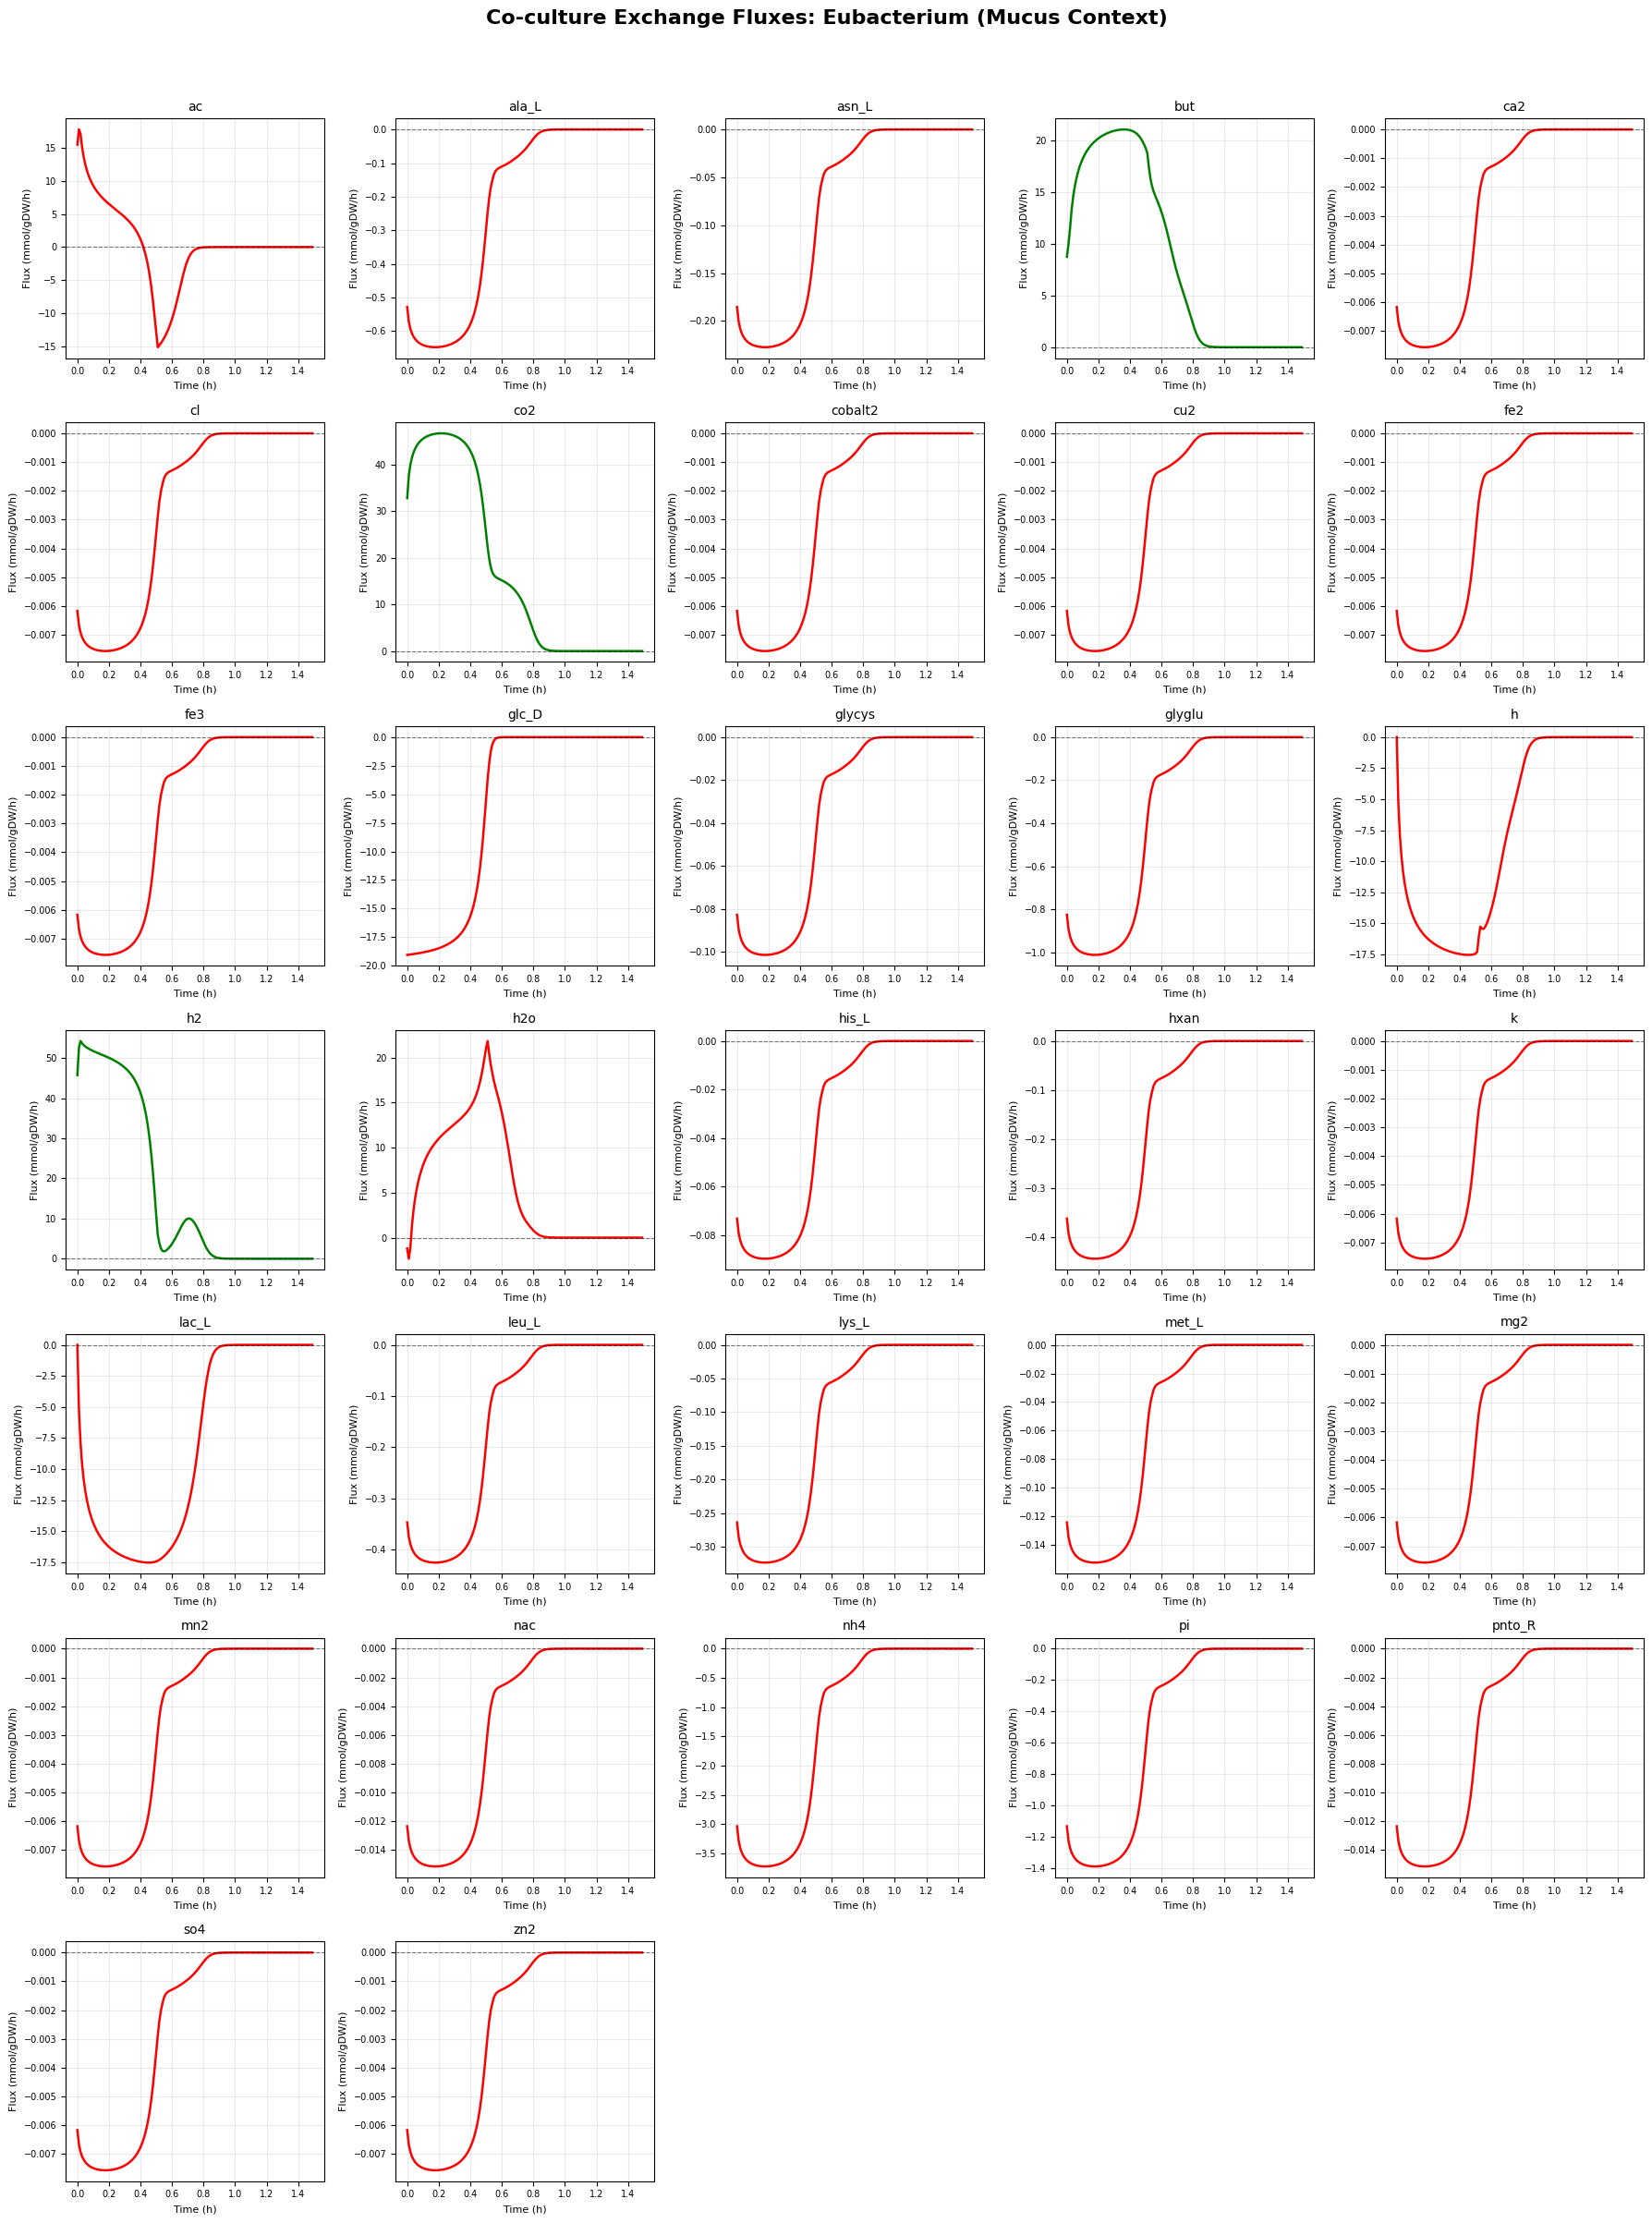

In [73]:
# Exchange Fluxes 
species_list = ['Bifido', 'Eubacterium']
time_flux = np.arange(len(sim_co.fluxes)) * t_step
flux_thresh = 1e-6

for sp in species_list:
    flux_df = sim_co.get_species_exchange_fluxes(sp, threshold=flux_thresh)
    ex_cols = [col for col in flux_df.columns if col.startswith('EX_') and 'biomass' not in col.lower()]
    sig_cols = [col for col in ex_cols if np.abs(flux_df[col].values).max() > flux_thresh]
    sig_cols = sorted(sig_cols)

    print(f"{sp}: {len(sig_cols)} significant exchange fluxes")

    if not sig_cols:
        continue

    cols = 5
    rows = math.ceil(len(sig_cols) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(18, 3.5 * rows))
    fig.suptitle(f'Co-culture Exchange Fluxes: {sp} (Mucus Context)',
                 fontsize=16, fontweight='bold', y=0.98)

    axes_flat = axes.flatten() if isinstance(axes, np.ndarray) else [axes]

    for i, col in enumerate(sig_cols):
        ax = axes_flat[i]
        vals = flux_df[col].values

        if vals.min() < -flux_thresh:
            color = 'red'
        elif vals.max() > flux_thresh:
            color = 'green'
        else:
            color = 'gray'

        ax.plot(time_flux[:len(vals)], vals, color=color, linewidth=1.8)
        ax.axhline(0, color='k', linestyle='--', linewidth=0.8, alpha=0.5)
        met_name = col.replace('EX_', '').replace('(e)', '')
        ax.set_title(met_name, fontsize=10)
        ax.set_xlabel('Time (h)', fontsize=8)
        ax.set_ylabel('Flux (mmol/gDW/h)', fontsize=8)
        ax.grid(alpha=0.25)
        ax.tick_params(axis='both', which='major', labelsize=7)

    for j in range(len(sig_cols), len(axes_flat)):
        fig.delaxes(axes_flat[j])

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


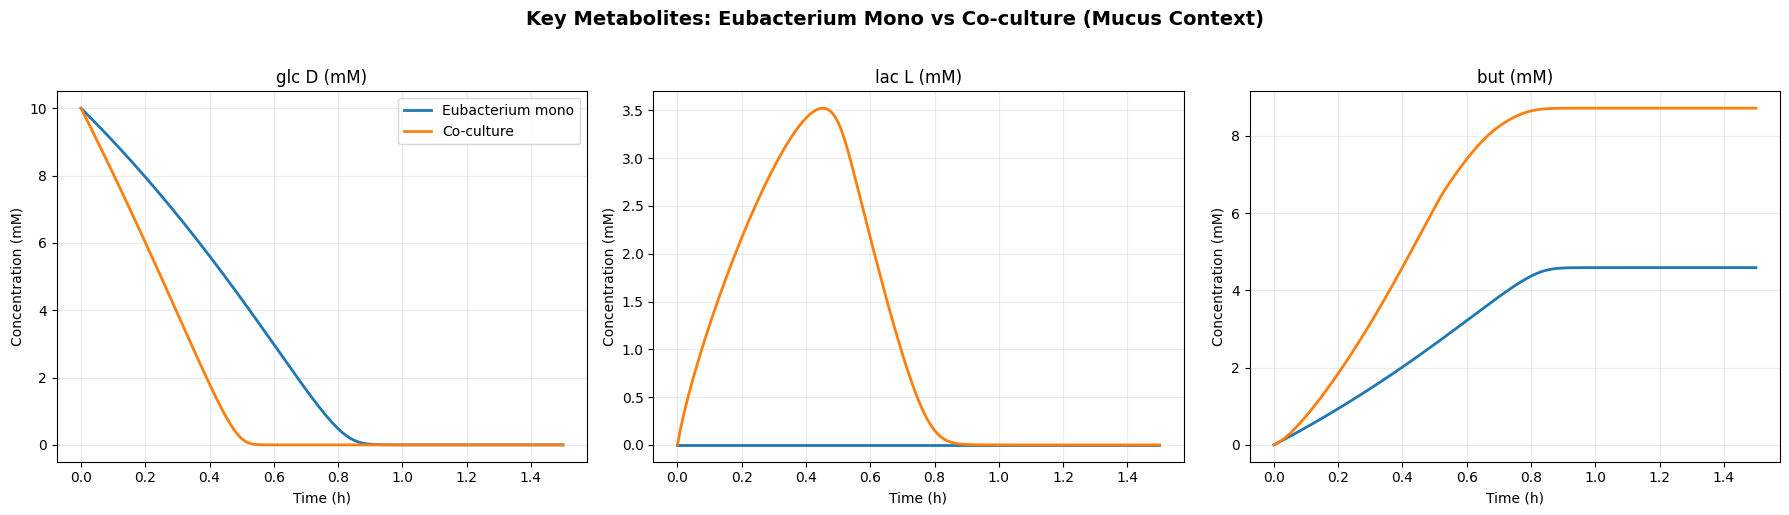

In [74]:
#Key Metabolites 
def met_ts(sim, met):
    df = sim.get_metabolite_time_series()
    if met in df.columns:
        return df[met].values / BOX_VOL_L  # convert to mM
    return np.zeros(len(df))

mets = ['glc_D[e]', 'lac_L[e]', 'but[e]']

media_mono_e = sim_mono_Eubacterium.get_metabolite_time_series()
media_co = sim_co.get_metabolite_time_series()
t_mono_e = np.arange(len(media_mono_e)) * t_step
t_co = np.arange(len(media_co)) * t_step

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Key Metabolites: Eubacterium Mono vs Co-culture (Mucus Context)',
             fontsize=14, fontweight='bold', y=1.02)

for ax, met in zip(axes, mets):
    ax.plot(t_mono_e, met_ts(sim_mono_Eubacterium, met), label='Eubacterium mono', lw=2)
    ax.plot(t_co, met_ts(sim_co, met), label='Co-culture', lw=2)
    met_label = met.replace('[e]', '').replace('_', ' ')
    ax.set_title(f'{met_label} (mM)')
    ax.set_xlabel('Time (h)')
    ax.set_ylabel('Concentration (mM)')
    ax.grid(alpha=0.25)
axes[0].legend()
plt.tight_layout()
plt.show()
